
 Examples and images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['image.cmap'] = 'gray'

In [3]:
im1 = np.load('im1.npy')

In [4]:
kw_fig = dict(cmap='gray',  vmin=-0.05, vmax=0.05,)
kw_fig_norm = dict(cmap='gray',  vmin=0, vmax=1,)

def compare_im(im1, im2, kwargs=kw_fig_norm):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
    ax1.imshow(im1, **kwargs)
    i = ax2.imshow(im2, **kwargs)
    plt.colorbar(i, ax=ax2)
    fig.tight_layout()
    



In [5]:
def apply_hysteresis_threshold(image, low, high):
    """Apply hysteresis thresholding to `image`.
    This algorithm finds regions where `image` is greater than `high`
    OR `image` is greater than `low` *and* that region is connected to
    a region greater than `high`.
    Parameters
    ----------
    image : array, shape (M,[ N, ..., P])
        Grayscale input image.
    low : float, or array of same shape as `image`
        Lower threshold.
    high : float, or array of same shape as `image`
        Higher threshold.
    Returns
    -------
    thresholded : array of bool, same shape as `image`
        Array in which `True` indicates the locations where `image`
        was above the hysteresis threshold.
    Examples
    --------
    >>> image = np.array([1, 2, 3, 2, 1, 2, 1, 3, 2])
    >>> apply_hysteresis_threshold(image, 1.5, 2.5).astype(int)
    array([0, 1, 1, 1, 0, 0, 0, 1, 1])
    References
    ----------
    .. [1] J. Canny. A computational approach to edge detection.
           IEEE Transactions on Pattern Analysis and Machine Intelligence.
           1986; vol. 8, pp.679-698.
           :DOI:`10.1109/TPAMI.1986.4767851`
    """
    low = np.clip(low, a_min=None, a_max=high)  # ensure low always below high
    mask_low = image > low
    mask_high = image > high
    # Connected components of mask_low
    labels_low, num_labels = ndi.label(mask_low)
    # Check which connected components contain pixels from mask_high
    sums = ndi.sum(mask_high, labels_low, np.arange(num_labels + 1))
    connected_to_high = sums > 0
    thresholded = connected_to_high[labels_low]
    return thresholded

## the funny part
* denoise
* thresholding
* dilation-erosion to connect along line
* hysteresis thresholding

In [6]:
import skimage
print(skimage.__version__)

0.13.0


In [7]:
from scipy import ndimage as ndi

from skimage import img_as_float
from skimage import filters
from skimage import restoration as rest
from skimage import morphology as morp
from skimage.exposure import rescale_intensity, histogram


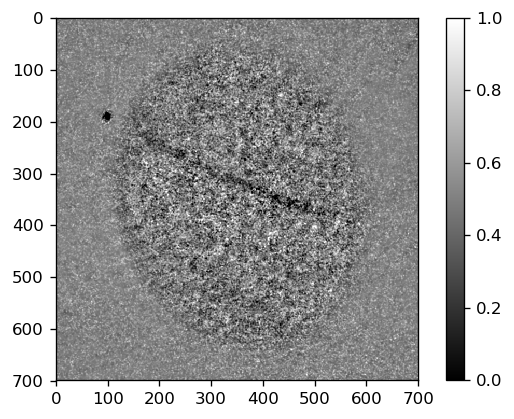

In [8]:
plt.imshow(im1, cmap='gray')
plt.colorbar()

## Denoising

In [9]:
im1_denoise_nlm = rest.denoise_nl_means(im1, patch_size=10, h=0.05, fast_mode=True, multichannel=False)

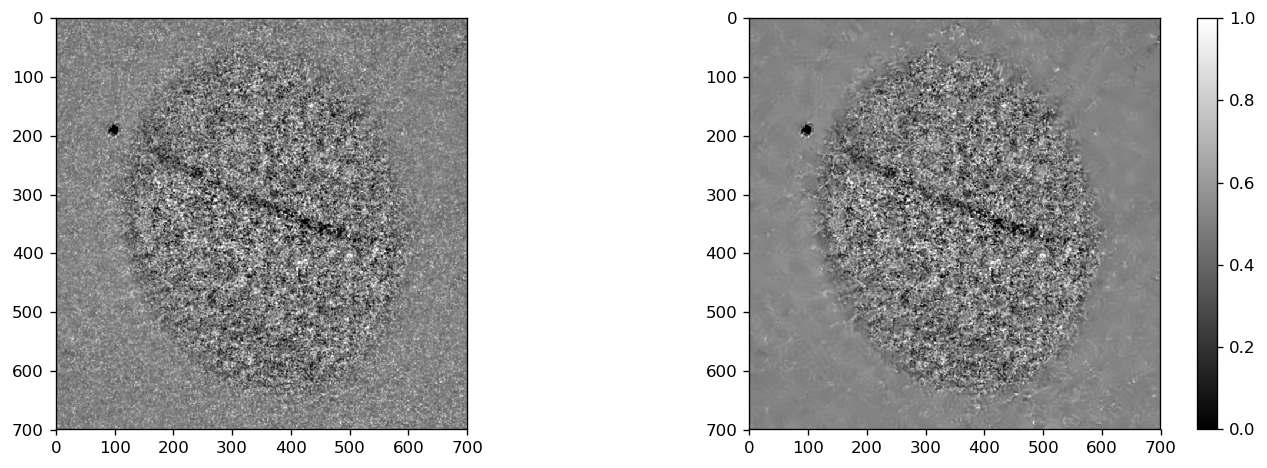

In [10]:
compare_im(im1, im1_denoise_nlm)

## Masking and other stuff

In [11]:
brute_mask = im1_denoise_nlm <= 0.3

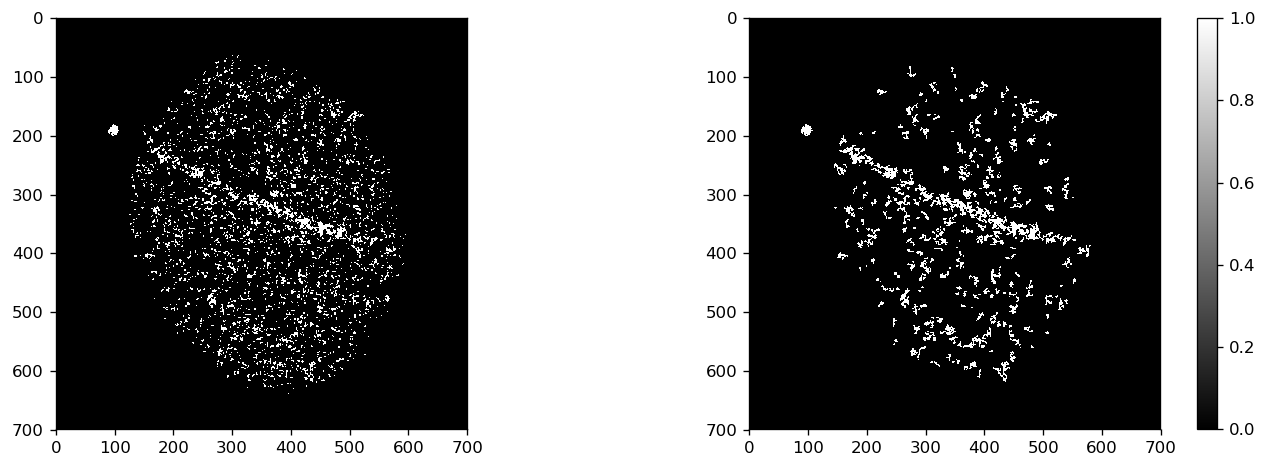

In [12]:
mask = apply_hysteresis_threshold(1 - im1_denoise_nlm, low=0.65, high=0.9)

compare_im(brute_mask, mask)

## Mask smoothing

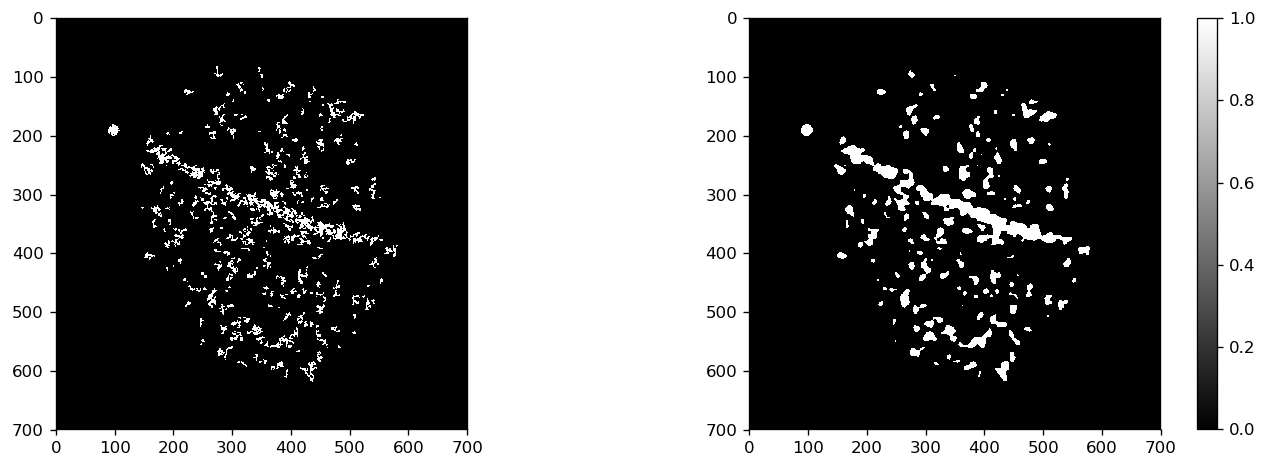

In [13]:
mask_sm = ndi.gaussian_filter(img_as_float(mask), sigma=3)
mask_sm = mask_sm >= 0.3
compare_im(mask, mask_sm)

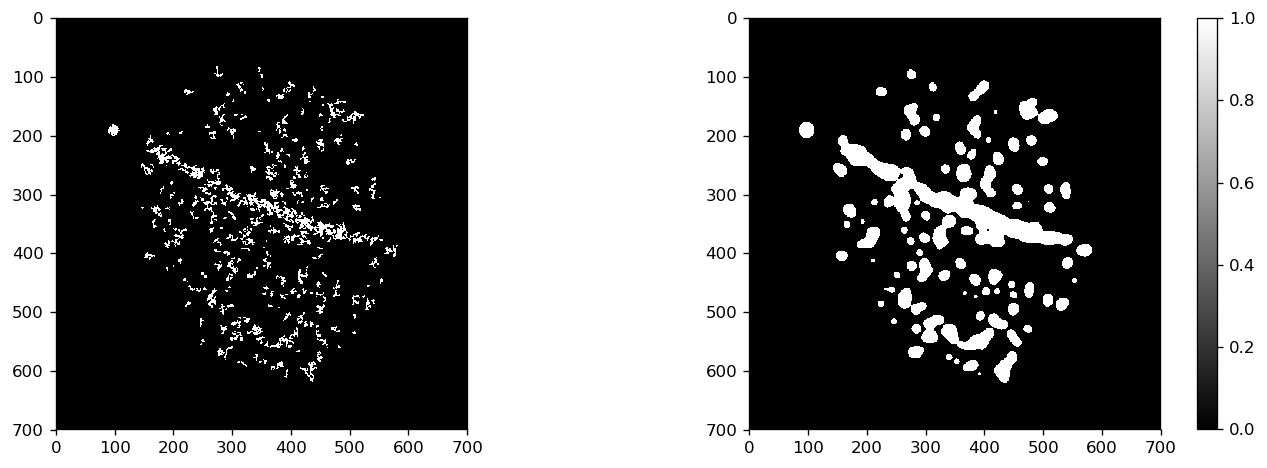

In [14]:
N = 4
mask_sm = mask
for _ in range(N):
    mask_sm = ndi.gaussian_filter(img_as_float(mask_sm), sigma=3)
    mask_sm = mask_sm >= 0.3
compare_im(mask, mask_sm)

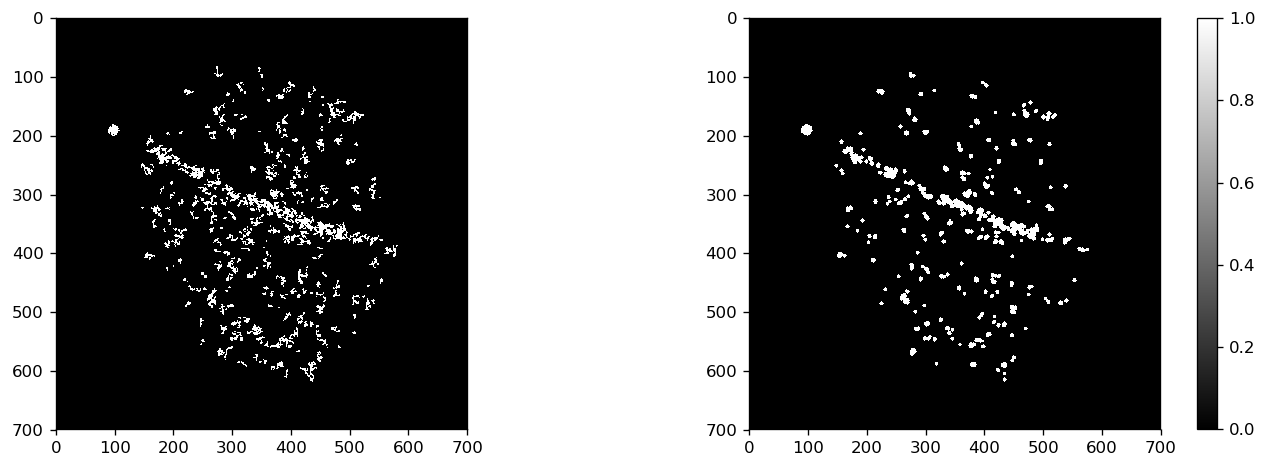

In [15]:
d2 = morp.disk(2)
d3 = morp.disk(3)
m1 = morp.erosion(mask, selem=d2)
mask_dilate = morp.dilation(m1, selem=d3)

compare_im(mask, mask_dilate)

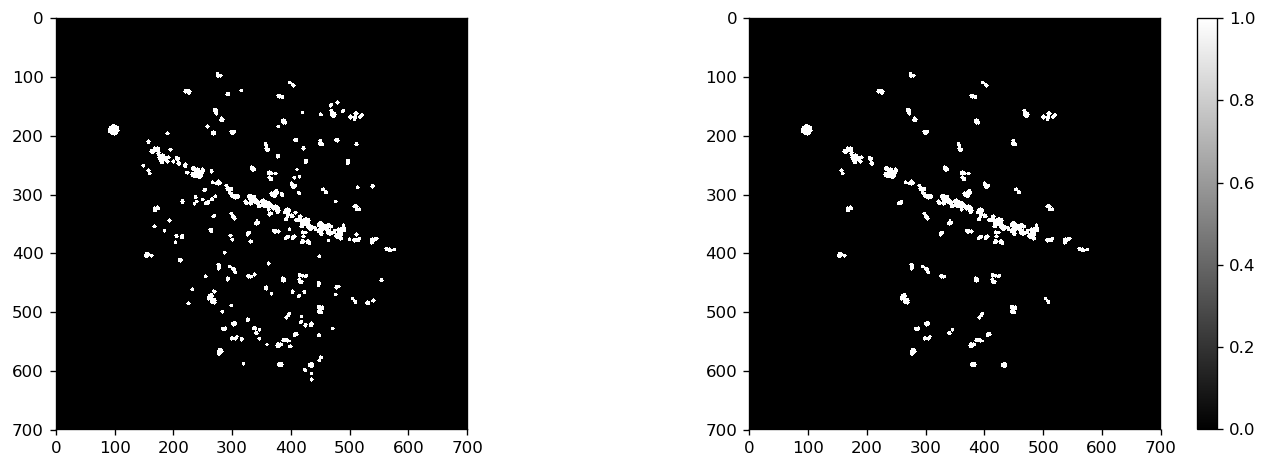

In [16]:
mask_removed = morp.remove_small_objects(mask_dilate)
compare_im(mask_dilate, mask_removed)

In [17]:
morp.remove_small_objects

<function skimage.morphology.misc.remove_small_objects(ar, min_size=64, connectivity=1, in_place=False)>

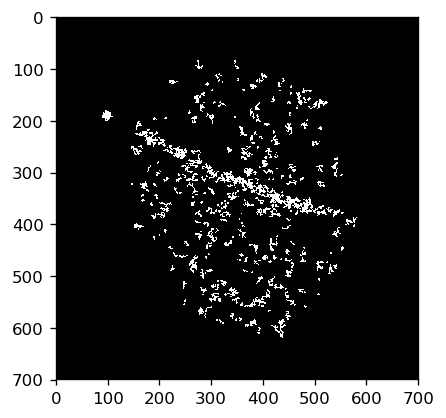

In [18]:
plt.imshow(mask)

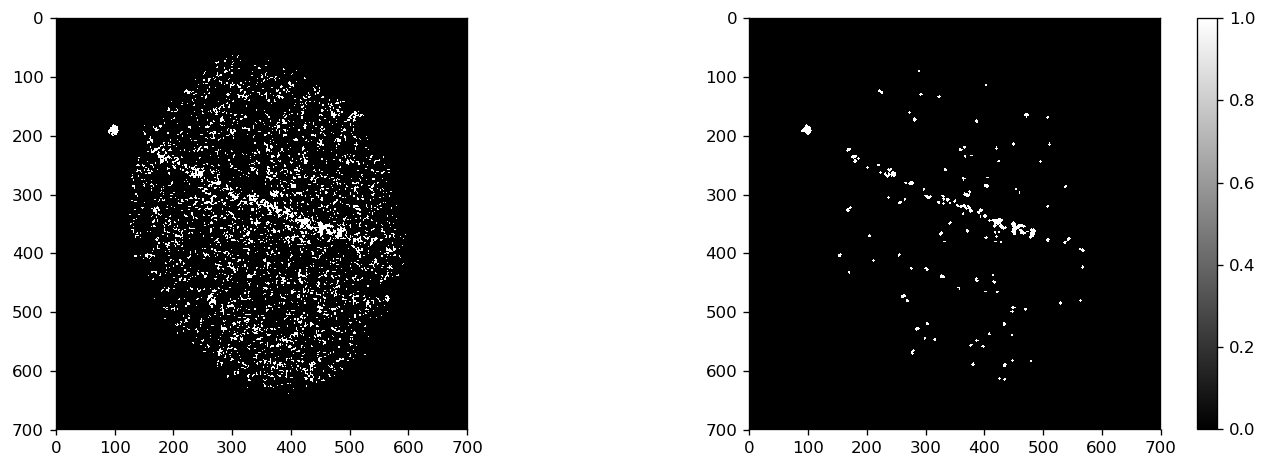

In [19]:
m1 = brute_mask
N = 2
for _ in range(N):
    m1 = morp.erosion(m1)
for _ in range(N):
    m1 = morp.dilation(m1)
compare_im(brute_mask, m1)

# ... to be continued :-)